<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151200 entries, 0 to 151199
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip.src           151200 non-null  object
 1   ip.dst           151200 non-null  object
 2   tcp.srcport      151200 non-null  int64 
 3   tcp.dstport      151200 non-null  int64 
 4   ip.proto         151200 non-null  int64 
 5   frame.len        151200 non-null  int64 
 6   tcp.flags.syn    151200 non-null  int64 
 7   tcp.flags.reset  151200 non-null  int64 
 8   tcp.flags.push   151200 non-null  int64 
 9   tcp.flags.ack    151200 non-null  int64 
 10  ip.flags.mf      151200 non-null  int64 
 11  ip.flags.df      151200 non-null  int64 
 12  ip.flags.rb      151200 non-null  int64 
 13  tcp.seq          151200 non-null  int64 
 14  tcp.ack          151200 non-null  int64 
 15  frame.time       151200 non-null  object
 16  Packets          151200 non-null  int64 
 17  Bytes     

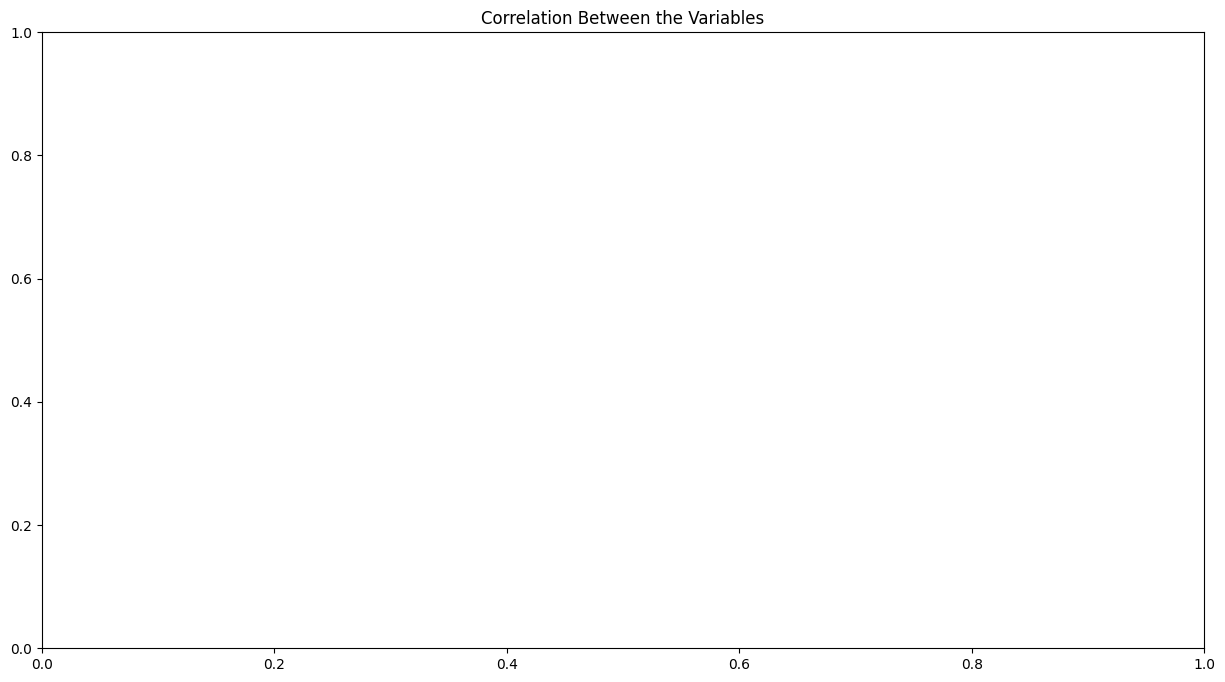

Count for class 0 (Benign): 60431
Count for class 1 (DDoS): 60529
Accuracy: 100.00%


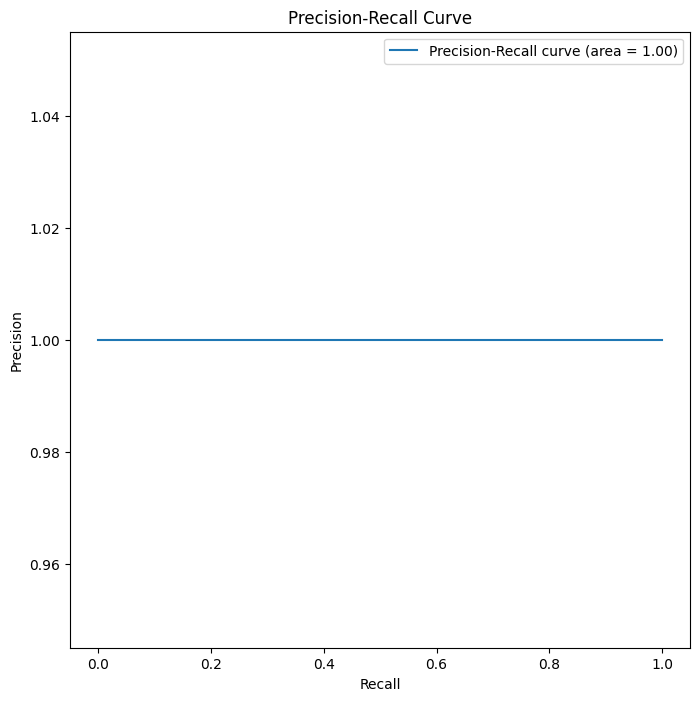

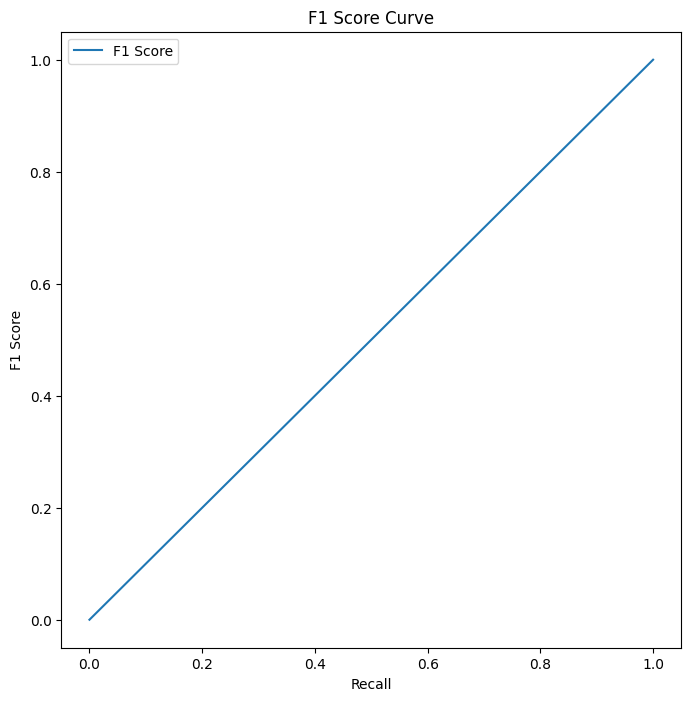

Model saved as ddos_detection_model.pkl


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib


ddos=pd.read_csv("./APA-DDoS-Dataset.csv")

ddos.info()

ddos.isna().sum()

ddos.groupby('Label').size()

# sns.pairplot(ddos, hue = 'Label', size = 2, diag_kind = 'kde')
# plt.show()

numeric_data = ddos.select_dtypes(include='number')# select only the columns in the DataFrame data that have numeric (number) data
correlation_matrix = numeric_data.corr()
fig, ax = plt.subplots(figsize=(15,8))
# sns.heatmap(correlation_matrix, annot=True,ax=ax,  cmap="RdPu")
plt.title('Correlation Between the Variables')
#plt.xticks(rotation=45);
plt.show()


columns_to_drop = ['tcp.dstport', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.reset', 'tcp.flags.ack', 'ip.flags.mf', 'ip.flags.rb', 'tcp.seq', 'tcp.ack']
ddos_new= ddos.drop(columns=columns_to_drop).copy()
ddos_new


ddos_new= ddos_new.drop(columns=['frame.time'])
ddos_new




# Assuming your DataFrame is named df
ddos_new['Label_new'] = ddos_new['Label'].apply(lambda x: 'Benign' if x == 'Benign' else 'DDoS')
ddos_new.drop(columns=['Label'], inplace=True)
ddos_new.rename(columns={'Label_new': 'Label'}, inplace=True)
ddos_new


y = ddos_new['Label']
y


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


X = ddos_new.drop(columns=['Label']).copy()


categorical_columns = ['ip.src', 'ip.dst']# Select categorical columns for one-hot encoding

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'
)


pipeline = Pipeline(steps=[('preprocessor', preprocessor)])# Create a pipeline


X_encoded = pipeline.fit_transform(X)# Fit and transform

# Get the column names after encoding
encoded_column_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns)
column_names = list(encoded_column_names) + list(X.columns.difference(categorical_columns))


X = pd.DataFrame(X_encoded, columns=column_names)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Split the data into training and testing sets


class_counts = np.bincount(y_train)
print(f'Count for class 0 (Benign): {class_counts[0]}')
print(f'Count for class 1 (DDoS): {class_counts[1]}')


rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)#  predict

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot precision-recall curve
fig, ax = plt.subplots(figsize=(8, 8))
precision, recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
area = auc(recall, precision)

plt.plot(recall, precision, label=f'Precision-Recall curve (area = {area:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot F1 score
fig, ax = plt.subplots(figsize=(8, 8))
f1 = 2 * (precision * recall) / (precision + recall)
plt.plot(recall, f1, label='F1 Score')
plt.xlabel('Recall')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend(loc='best')
plt.show()

# Save the trained model
# joblib.dump(rf_model, 'ddos_detection_model.pkl')
# print("Model saved as ddos_detection_model.pkl")